# Neural Coding

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = bd.vision.MNIST('./data', download=True)
r = mnist[129][0]

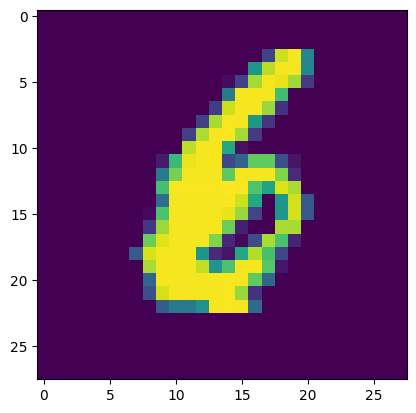

In [3]:
plt.imshow(r)

## Rate Coding

One example of converting input data into a rate code is as follows. 
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike. 


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
d:\codes\projects\brainpy\brainpy\_src\math\compat_numpy.py:164: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  res = jnp.asarray(a=a, dtype=dtype, order=order)


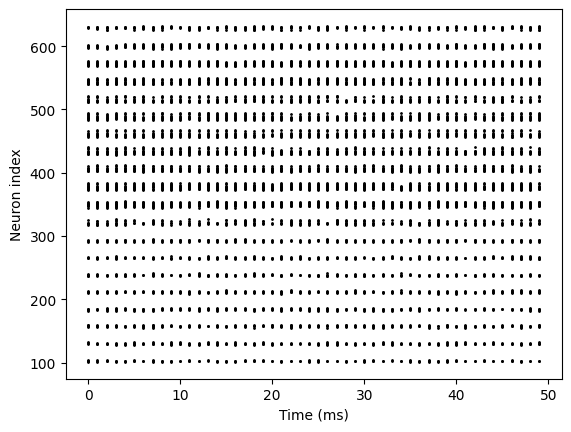

In [4]:
encoder = bp.encoding.PoissonEncoder(min_val=0, max_val=255)
sps = encoder.multi_steps(r.flatten(), n_time=5.)  # 5 ms, dt=0.1 ms 
bp.visualize.raster_plot(np.arange(50), sps, show=True)

MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let’s do that again but reduce the spiking frequency. This can be achieved by setting the argument gain. Here, we will reduce spiking frequency to 25%.

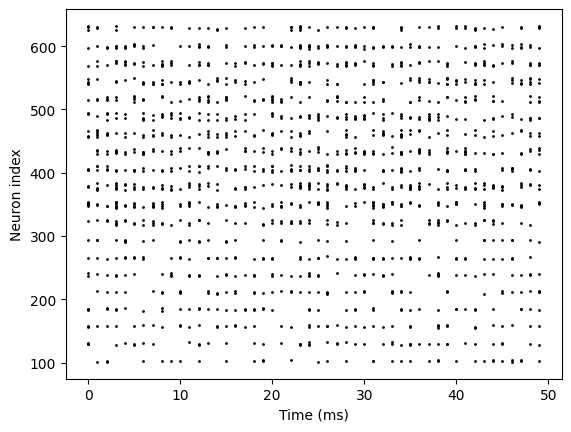

In [5]:
encoder = bp.encoding.PoissonEncoder(min_val=0, max_val=255, gain=0.25)
sps = encoder.multi_steps(r.flatten(), n_time=5.)  # 5 ms, dt=0.1 ms 
bp.visualize.raster_plot(np.arange(50), sps, show=True)

## Latency Coding

Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

The key of **latency coding**: *big input means fast spike; small input means late spike.*

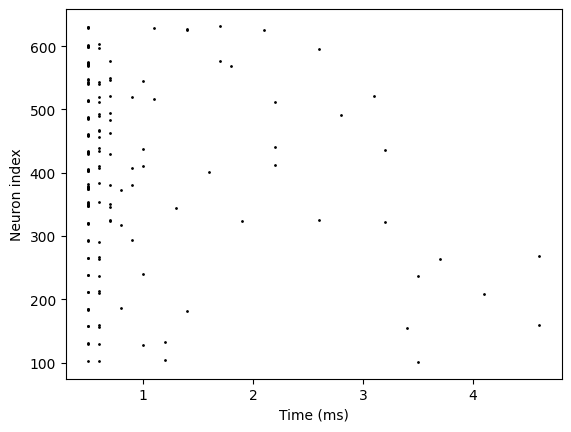

In [6]:
encoder = bp.encoding.LatencyEncoder(normalize=True, tau=1., threshold=0.1, method='log')
sps = encoder.multi_steps(r.flatten() / 255, n_time=5.)  # 5 ms, dt=0.1 ms 
bp.visualize.raster_plot(np.arange(50) * bm.dt, sps, show=True)

Some of the arguments include:

- ``tau``: the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher tau will induce slower firing.
- ``threshold``: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.tep.

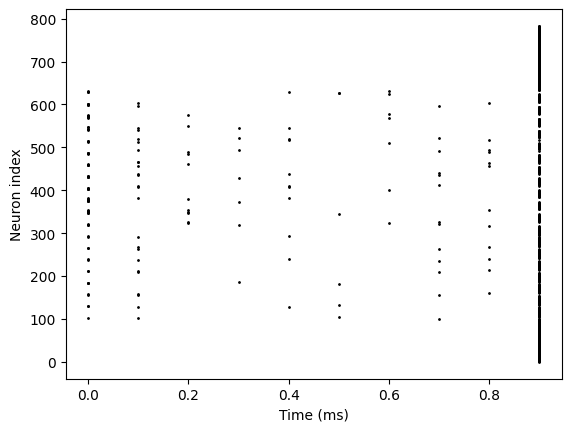

In [7]:
encoder = bp.encoding.LatencyEncoder(normalize=False, tau=1., threshold=0.0, clip=True, method='linear')
sps = encoder.multi_steps(r.flatten() / 255, n_time=5.)  # 5 ms, dt=0.1 ms 
bp.visualize.raster_plot(np.arange(50) * bm.dt, sps, show=True)

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by sett``ing clip=``True.

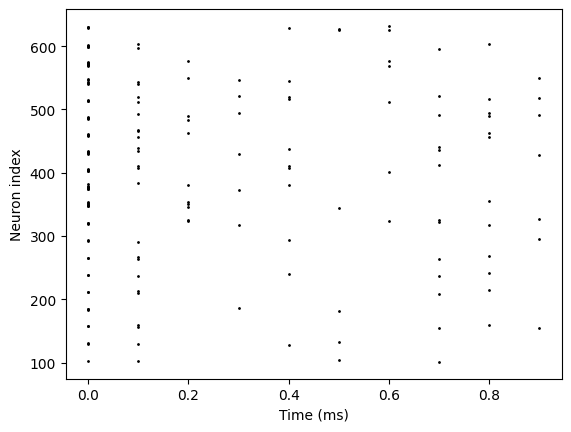

In [8]:
encoder = bp.encoding.LatencyEncoder(normalize=False, tau=1., threshold=0.01, clip=True, method='linear')
sps = encoder.multi_steps(r.flatten() / 255, n_time=5.)  # 5 ms, dt=0.1 ms 
bp.visualize.raster_plot(np.arange(50) * bm.dt, sps, show=True)

## Delta modulation

There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are less prone to firing.

That is to say: **biology is event-driven**. Neurons thrive on change.

To illustrate, let’s first come up with a contrived example where we create our own input tensor.

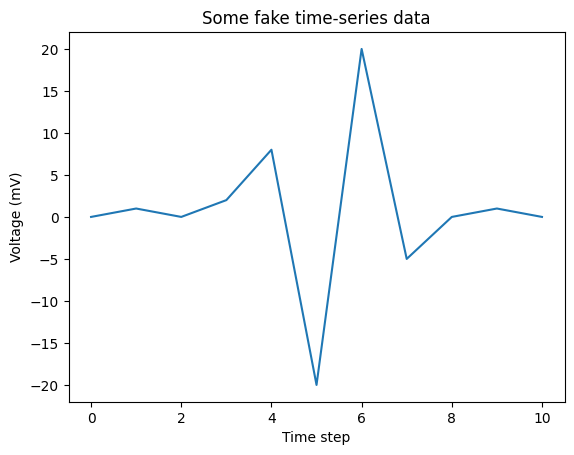

In [9]:
# Create a tensor with some fake time-series data
data = bm.Array([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])
# Plot the tensor
plt.plot(data)
plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

Pass the above tensor into the brainpy ``DiffEncoder`` function:

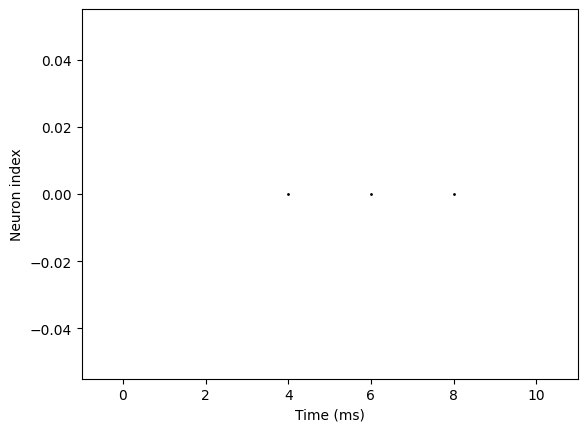

In [12]:
encoder = bp.encoding.DiffEncoder(threshold=4., off_spike=True)
r = encoder.multi_steps(bm.expand_dims(data, 1))
bp.visualize.raster_plot(bm.arange(data.size), r, xlim=(-1, data.size), show=True)